In [2]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

# Read Actual Bounding Boxes

In [3]:
file = open('../Data/Source_Images/Test_Images/data_test.txt', 'r')
file_names = []
xmin = []
ymin = []
xmax = []
ymax = []

line = file.readline()
while line:
    line_split = line.split()
    
    boxes = line_split[1:]
    for i in range(0, len(boxes)):
        boxes[i] = list(map(int, boxes[i].split(',')))
        file_names.append(line_split[0].split('/')[-1]) 
        xmin.append(boxes[i][0])
        ymin.append(boxes[i][1])
        xmax.append(boxes[i][2])
        ymax.append(boxes[i][3])

    line = file.readline()        
file.close()

actual = pd.DataFrame({'image': file_names,
                       'xmin': xmin,
                       'ymin': ymin,
                       'xmax': xmax,
                       'ymax': ymax})
actual

,image,xmin,ymin,xmax,ymax
0,0021015f976e9ac9.jpg,272,15,1017,611
1,00228d70340dbb12.jpg,601,721,635,741
2,0022956940f4b895.jpg,255,111,554,471
3,0025cd9a44e1ee15.jpg,288,88,736,632
4,0027bab0eaca538b.jpg,401,82,617,335
...,...,...,...,...,...
12018,307d5ac16ddbebda.jpg,140,105,361,312
12019,307d5ac16ddbebda.jpg,650,121,883,376
12020,3082acf9014751d3.jpg,485,173,577,274
12021,3082acf9014751d3.jpg,241,120,405,278


# Read Predicted Bounding Boxes

In [4]:
useMedianFilter = True
useHistogramEqualisation = True

predicted = pd.read_csv('../Data/Source_Images/Test_Image_Detection_Results/Detection_Results_Median_'
                        +str(useMedianFilter) + 'HistogramEq_'+str(useHistogramEqualisation) + '.csv')
predicted

FileNotFoundError: [Errno 2] No such file or directory: '../Data/Source_Images/Test_Image_Detection_Results/Detection_Results_Median_TrueHistogramEq_True.csv'

# Evaluate (Intersection Over Union)

In [4]:
def bb_intersection_over_union(boxesA, boxesB):
    ious = []
    for boxA in boxesA.iterrows():
        boxA_ious = []
        boxA = boxA[1]
        
        for boxB in boxesB.iterrows():
            boxB = boxB[1]

            xA = max(boxA['xmin'], boxB['xmin'])
            yA = max(boxA['ymin'], boxB['ymin'])
            xB = min(boxA['xmax'], boxB['xmax'])
            yB = min(boxA['ymax'], boxB['ymax'])

            inter_area = max(0, xB - xA + 1) * max(0, yB - yA + 1)
            
            # compute the area of both the prediction and ground-truth
            # rectangles
            boxA_area = (boxA['xmax'] - boxA['xmin'] + 1) * (boxA['ymax'] - boxA['ymin'] + 1)
            boxB_area = (boxB['xmax'] - boxB['xmin'] + 1) * (boxB['ymax'] - boxB['ymin'] + 1)
            
            # compute the intersection over union by taking the intersection
            # area and dividing it by the sum of prediction + ground-truth
            # areas - the interesection area
            boxA_ious.append(inter_area / float(boxA_area + boxB_area - inter_area))
        
        if (len(boxA_ious) == 0):
            ious.append(0)
        else:
            ious.append(max(boxA_ious))
    
    return np.array(ious)        

In [5]:
ious = np.array([])
for file in actual['image'].unique():
    iou = bb_intersection_over_union(actual[actual['image'] == file], predicted[predicted['image'] == file])
    ious = np.concatenate((ious, iou), axis=None)

# mean iou
print(np.mean(ious))

# zero intersection ratio
zero_ratio = (ious == 0).sum() / ious.shape[0]
print(zero_ratio)

# non zero ratio
print(1 - zero_ratio)

0.5721694812941167
0.23523809523809525
0.7647619047619048


In [20]:
def plot_history(history):
    loss_list = [s for s in history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history[l], 'b', label='Training loss (' + str(str(format(history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history[l], 'g', label='Validation loss (' + str(str(format(history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()


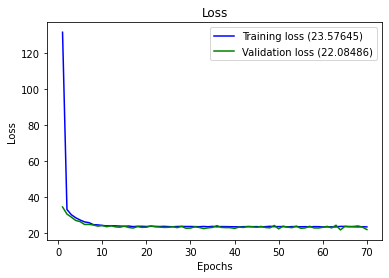

In [21]:
with open('../Data/Model_Weights/history_stage_1.pkl', 'rb') as history_file:
    history = pickle.load(history_file)
plot_history(history)

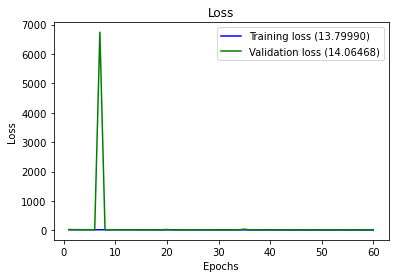

In [22]:
with open('../Data/Model_Weights/history_final.pkl', 'rb') as history_file:
    history = pickle.load(history_file)
plot_history(history)